# Road and Ferry Transport Network of Bicol Region

## 0 Preliminaries

In [1]:
import os
import warnings

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import pandas as pd
from geopy.distance import geodesic
from matplotlib.axes import Axes
from scipy.spatial import cKDTree

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = os.path.join(".", "outputs")
GDF_BOUNDS = gpd.read_file(os.path.join(BASE_PATH, "boundaries.gpkg"))

ORIGIN_TOWN = "Legazpi City"

In [3]:
def plot_with_basemap(
    ax: Axes,
    title: str,
    filename: str = None,
    padding: float = 0.1,
) -> None:
    x_min, y_min, x_max, y_max = GDF_BOUNDS.total_bounds
    ax.set_xlim(x_min - padding, x_max + padding)
    ax.set_ylim(y_min - padding, y_max + padding)

    cx.add_basemap(
        ax,
        crs=GDF_BOUNDS.crs,
        source=cx.providers.CartoDB.Positron,
        attribution="",
    )

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()

    if filename:
        filepath = os.path.join(BASE_PATH, filename)
        plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()


def get_labeled_undirected_graph(
    G: nx.MultiDiGraph,
    mode: str,
) -> nx.MultiGraph:
    G = G.to_undirected()

    for _, data in G.nodes(data=True):
        data["mode"] = mode
    for _, _, data in G.edges(data=True):
        data["mode"] = mode

    return G

## 1 Generate road network

In [4]:
graph_roads = ox.graph_from_place(
    "Bicol Region",
    network_type="drive_service",
    simplify=False,
    retain_all=True,
)

graph_roads = get_labeled_undirected_graph(graph_roads, "road")

len(graph_roads.nodes), len(graph_roads.edges)

(446869, 460990)

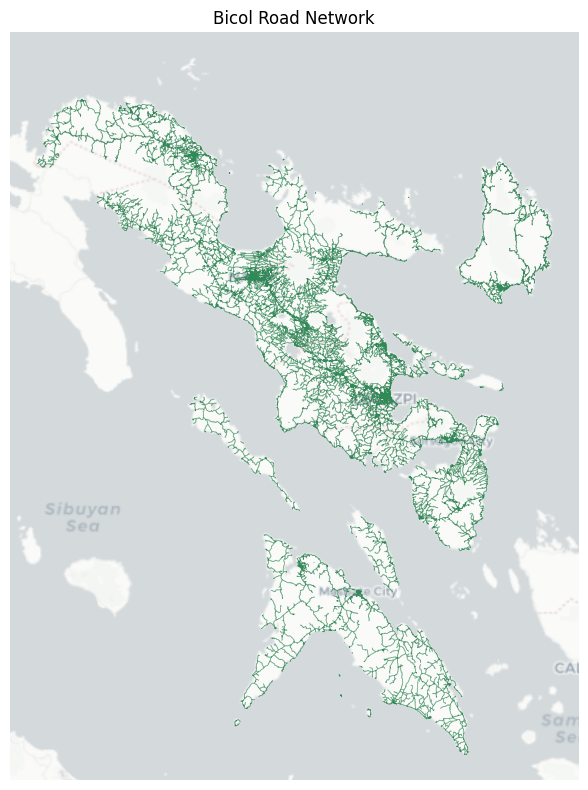

In [5]:
_, ax = plt.subplots(figsize=(8, 8))

ox.plot_graph(
    graph_roads,
    ax=ax,
    node_size=0,
    edge_color="seagreen",
    edge_linewidth=0.5,
    show=False,
    close=False,
)

plot_with_basemap(
    ax,
    title="Bicol Road Network",
    filename="road_network.png",
)

In [6]:
filepath = os.path.join(BASE_PATH, "road_network.graphml")
ox.save_graphml(graph_roads, filepath=filepath)

## 3 Initial road-only accessibility analysis

In [7]:
def get_accessible_towns(
    graph: nx.Graph,
) -> pd.Series:
    orig_geom = GDF_BOUNDS[GDF_BOUNDS["town"] == ORIGIN_TOWN].union_all()
    orig_point = orig_geom.centroid
    orig_node = ox.nearest_nodes(graph, orig_point.x, orig_point.y)

    reach_nodes = {orig_node} | nx.descendants(graph, orig_node)
    reach_graph = graph.subgraph(reach_nodes)
    gdf_reach_edges = ox.graph_to_gdfs(reach_graph, nodes=False, edges=True)

    if gdf_reach_edges.empty:
        reach_towns = set()
    else:
        gdf_reachable_towns = gpd.sjoin(
            GDF_BOUNDS,
            gdf_reach_edges,
            how="inner",
            predicate="intersects",
        )
        reach_towns = set(gdf_reachable_towns["town"].unique())

    return reach_towns


def plot_accessibility_map(
    accessible_towns: set[str],
    title: str,
    filename: str = None,
) -> None:
    _, ax = plt.subplots(figsize=(8, 8))

    origin = GDF_BOUNDS[GDF_BOUNDS["town"] == ORIGIN_TOWN]

    mask = GDF_BOUNDS["town"].isin(accessible_towns)
    reachable = GDF_BOUNDS[mask]
    unreachable = GDF_BOUNDS[~mask]

    reachable.plot(
        ax=ax,
        color="seagreen",
        edgecolor="white",
        linewidth=0.5,
        label="Accessible",
    )

    origin.plot(
        ax=ax,
        color="peru",
        edgecolor="white",
        linewidth=0.5,
        label="Origin",
    )

    if not unreachable.empty:
        unreachable.plot(
            ax=ax,
            color="firebrick",
            edgecolor="white",
            linewidth=0.5,
            label="Inaccessible",
        )

    plot_with_basemap(ax=ax, title=title, filename=filename)

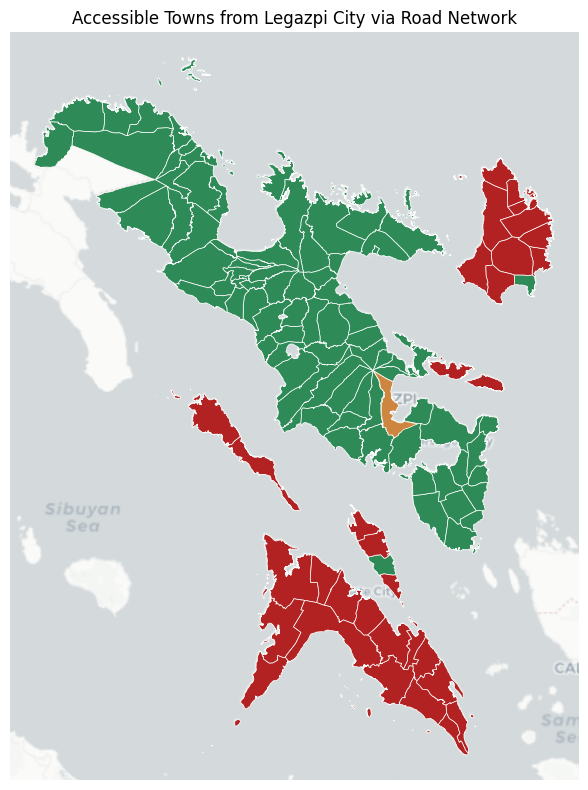

In [8]:
accessible_towns = get_accessible_towns(graph=graph_roads)

plot_accessibility_map(
    accessible_towns=accessible_towns,
    title=f"Accessible Towns from {ORIGIN_TOWN} via Road Network",
    filename="initial_accessibility_map.png",
)

## 4 Load ferry transport network

In [9]:
graph_ferry = ox.graph_from_place(
    "Bicol Region",
    custom_filter='["route"="ferry"]',
    retain_all=True,
    simplify=False,
)

graph_ferry = get_labeled_undirected_graph(graph_ferry, "ferry")

len(graph_ferry.nodes), len(graph_ferry.edges)

(1087, 1060)

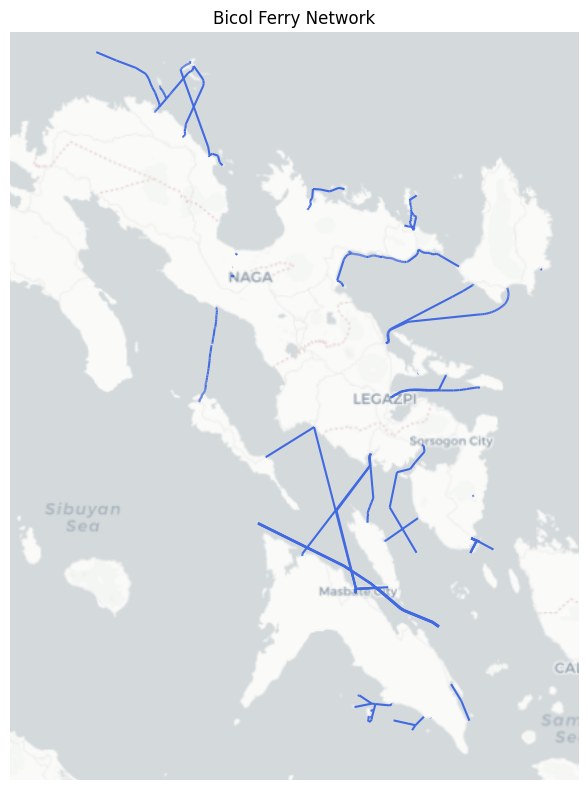

In [10]:
_, ax = plt.subplots(figsize=(8, 8))

ox.plot_graph(
    graph_ferry,
    ax=ax,
    node_size=0,
    edge_color="royalblue",
    edge_linewidth=1.5,
    show=False,
    close=False,
)

plot_with_basemap(
    ax,
    title="Bicol Ferry Network",
    filename="ferry_network.png",
)

In [11]:
filepath = os.path.join(BASE_PATH, "ferry_network.graphml")
ox.save_graphml(graph_ferry, filepath=filepath)

## 5 Merge road and ferry networks

In [ ]:
def merge_networks(
    graph_roads: nx.MultiDiGraph,
    graph_ferry: nx.MultiDiGraph,
    max_dist_m: int = 500,
) -> nx.MultiDiGraph:
    graph_merged = nx.compose(graph_roads, graph_ferry)

    nodes = ox.graph_to_gdfs(graph_merged, edges=False)[["x", "y", "mode"]]
    ferry_nodes = nodes[nodes["mode"] == "ferry"]
    road_nodes = nodes[nodes["mode"] == "road"]
    tree = cKDTree(road_nodes[["y", "x"]].values)

    for s_id, s_data in ferry_nodes.iterrows():
        s_coord = (s_data["y"], s_data["x"])
        _, idx = tree.query(s_coord, k=1)

        l_id = road_nodes.index[idx]
        l_coord = (road_nodes.iloc[idx]["y"], road_nodes.iloc[idx]["x"])
        dist_m = geodesic(s_coord, l_coord).meters

        if dist_m <= max_dist_m:
            for u, v in [(s_id, l_id), (l_id, s_id)]:
                graph_merged.add_edge(u, v, length=dist_m, mode="road")

    return graph_merged


def prune_terminal_ferry_nodes(G: nx.MultiDiGraph) -> nx.MultiDiGraph:
    graph_pruned = G.copy()

    while True:
        terminal_nodes_to_remove = [
            node
            for node, degree in graph_pruned.degree()
            if degree == 1 and graph_pruned.nodes[node].get("mode") == "ferry"
        ]
        if not terminal_nodes_to_remove:
            break
        graph_pruned.remove_nodes_from(terminal_nodes_to_remove)

    return graph_pruned

In [13]:
graph_merged = merge_networks(graph_roads, graph_ferry)
graph_merged = prune_terminal_ferry_nodes(graph_merged)

filepath = os.path.join(BASE_PATH, "merged_network_full.graphml")
ox.save_graphml(graph_merged, filepath)

graph_merged.number_of_nodes(), graph_merged.number_of_edges()

(447510, 462305)

In [14]:
graph_merged = nx.MultiDiGraph(graph_merged)
graph_merged = ox.simplify_graph(graph_merged)
graph_merged = graph_merged.to_undirected()

filepath = os.path.join(BASE_PATH, "merged_network_simplified.graphml")
ox.save_graphml(graph_merged, filepath)

graph_merged.number_of_nodes(), graph_merged.number_of_edges()

(56932, 71895)

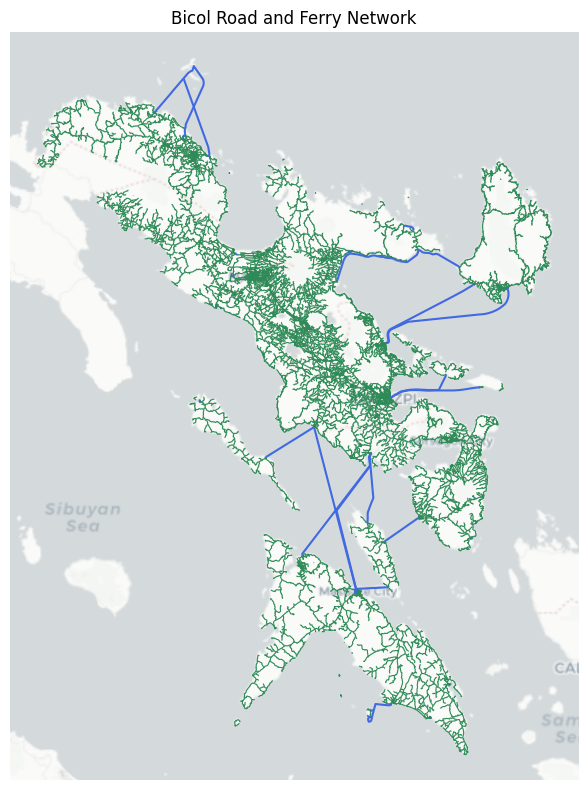

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

_, edges = ox.graph_to_gdfs(graph_merged)
edges = edges.reset_index()

edges[edges["mode"] == "road"].plot(
    ax=ax,
    color="seagreen",
    linewidth=0.8,
    label="Road Network",
)
edges[edges["mode"] == "ferry"].plot(
    ax=ax,
    color="royalblue",
    linewidth=1.5,
    label="Ferry Routes",
)

plot_with_basemap(
    ax=ax,
    title="Bicol Road and Ferry Network",
    filename="merged_network.png",
)

## 6 Final accessibility analysis

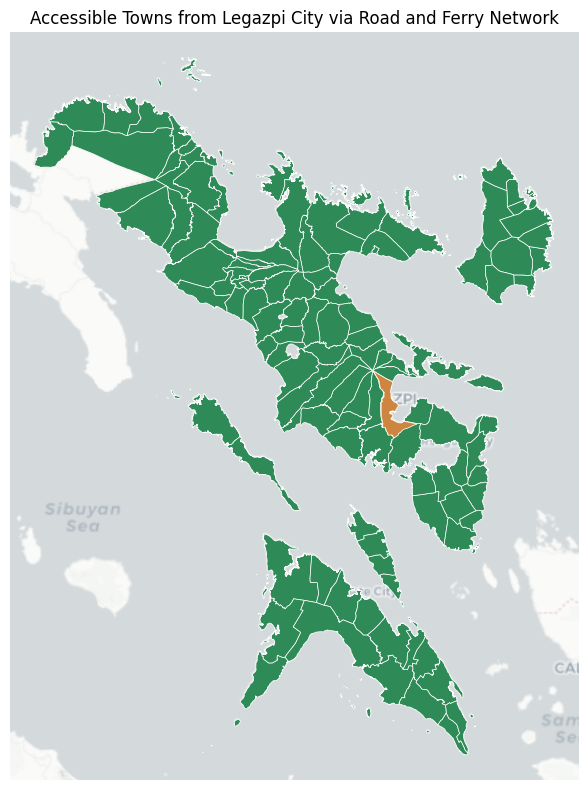

In [ ]:
accessible_towns = get_accessible_towns(graph=graph_merged)

plot_accessibility_map(
    accessible_towns=accessible_towns,
    title=f"Accessible Towns from {ORIGIN_TOWN} via Road and Ferry Network",
    filename="final_accessibility_map.png",
)